In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [195]:
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# Use SQLAlchemy `create_engine` to connect to your sqlite database.

engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

##### Design a query to retrieve the last 12 months of precipitation data and plot the results

In [279]:
conn = engine.connect()
measurements = pd.read_sql("Select * From Measurement" ,conn)
measurements.head()
measurements.dtypes

#changing date coulmn to datetime format
measurements['date'] = pd.to_datetime(measurements['date'])
measurements.dtypes
measurements.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


##### Calculate the date 1 year ago from the last data point in the database

In [280]:
twelve_months_ago = measurements['date'].max() - pd.DateOffset(months=12)
print(f"The date 12 months ago was {twelve_months_ago}")

The date 12 months ago was 2016-08-23 00:00:00


###### Perform a query to retrieve the data and precipitation scores


In [281]:
twelve_month_data = measurements.loc[measurements['date'] >= twelve_months_ago]
tmd = twelve_month_data[['date','prcp']]
tmd.head()

,date,prcp
2363,2016-08-23,0.00
2364,2016-08-24,0.08
2365,2016-08-25,0.08
2366,2016-08-26,0.00
2367,2016-08-27,0.00


##### Save the query results as a Pandas DataFrame and set the index to the date column


In [282]:
twelve = pd.DataFrame(tmd)
twelve = twelve.set_index('date')
twelve.sort_index()
twelve.head()

,prcp
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


##### Sort the dataframe by date


In [283]:
twelve = twelve.sort_index()
twelve.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


##### Use Pandas Plotting with Matplotlib to plot the data


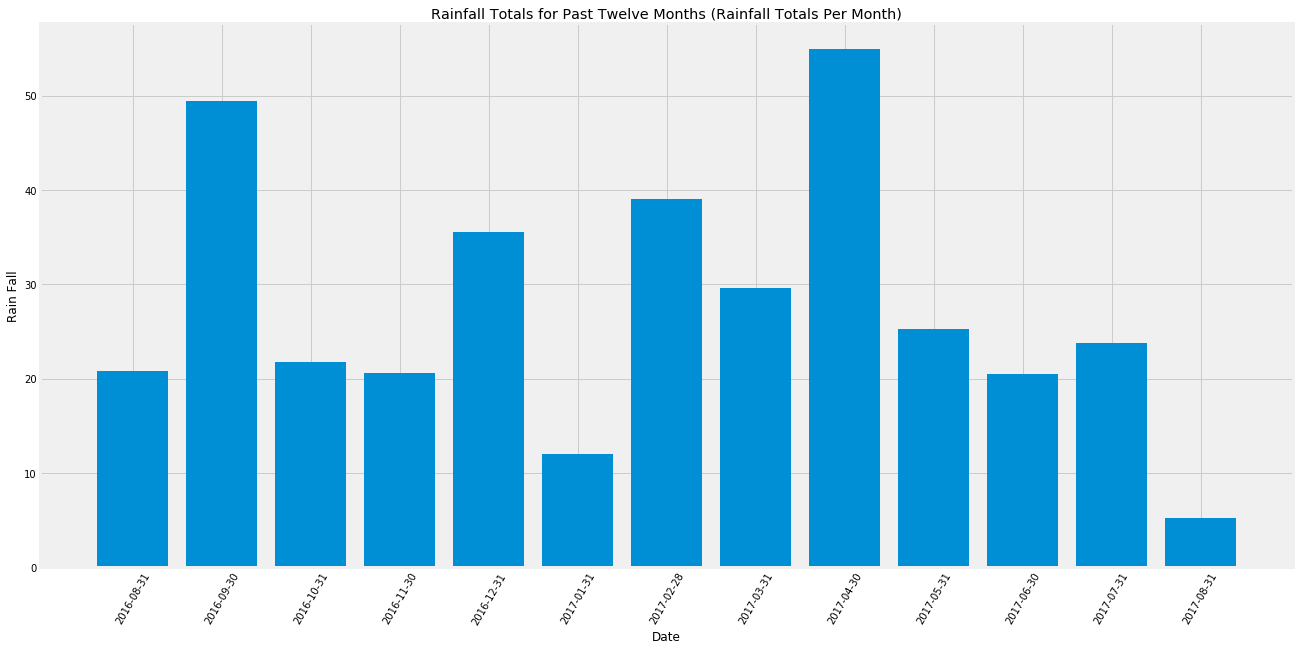

In [284]:
#prepping data to be plotted

#decided to add the prcp scores by month.
twelve = twelve.resample('M').sum()
twelve

tmd_sum = pd.DataFrame(twelve)
tmd_sum
tmd_sum = tmd_sum.reset_index()

#print(tmd_sum)

date = tmd_sum['date'].astype(str).tolist()
prcp = tmd_sum['prcp'].tolist()

#plotting
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(date,prcp)
ax.set_title("Rainfall Totals for Past Twelve Months (Rainfall Totals Per Month)")
plt.xticks(date,rotation=60)
ax.set_xlabel("Date")
ax.set_ylabel("Rain Fall")
plt.show()

In [285]:
#plotting again to look like example .png 

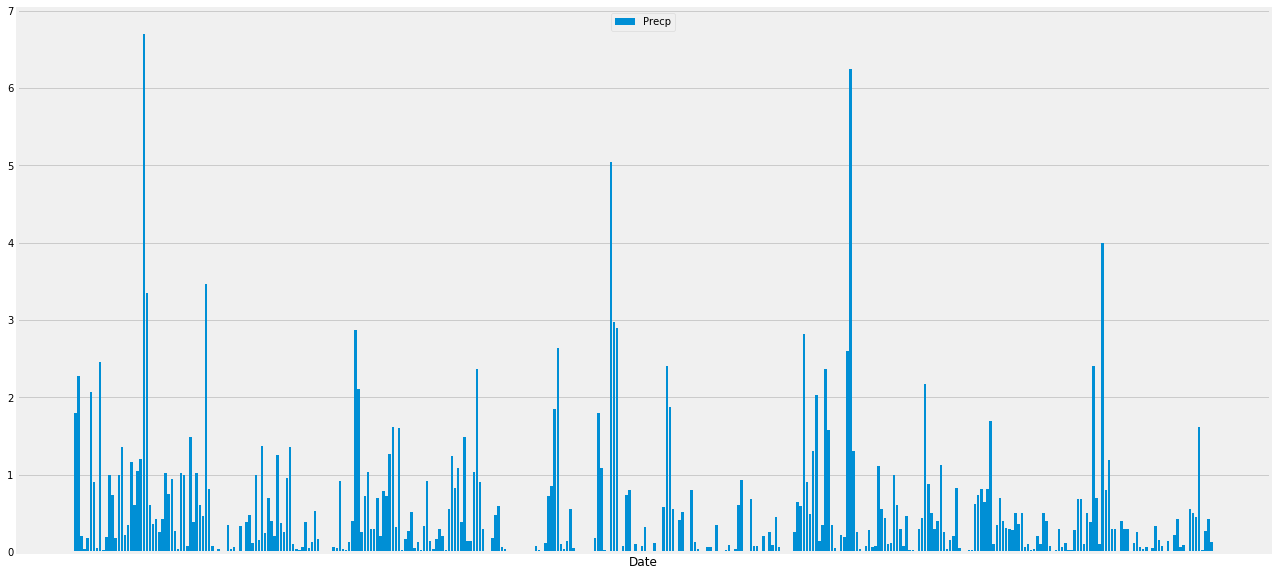

In [286]:
fig1, ax1 = plt.subplots(figsize=(20,10))

date1 = tmd['date'].astype(str).tolist()
prcp1 = tmd['prcp'].tolist()

ax1.bar(date1,prcp1)
plt.xlabel('Date')
#ax1.xaxis.set_visible(False)
ax1.set_xticks([])
ax1.legend(['Precp'],loc=9)
plt.show()


##### Use Pandas to calcualte the summary statistics for the precipitation data

In [287]:
tmd.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


##### Design a query to show how many stations are available in this dataset?


In [289]:
stations_count = pd.read_sql("Select count(distinct station) as '# Of Stations' from station" ,conn)
print(stations_count)
print(" ")
#or 

stations = session.query(func.count(Station.station)).all()
print(f'There are {stations} stations.')

   # Of Stations
0              9
 
There are [(9,)] stations.


##### What are the most active stations? (i.e. what stations have the most rows)?
###### List the stations and the counts in descending order.

In [290]:
stations = pd.read_sql("Select station,id, count(station) as 'Activity Count' from measurement group by station order by 3 desc",conn)
stations

,station,id,Activity Count
0,USC00519281,12188,2772
1,USC00519397,1,2724
2,USC00513117,2725,2709
3,USC00519523,9519,2669
4,USC00516128,16939,2612
5,USC00514830,5434,2202
6,USC00511918,14960,1979
7,USC00517948,7636,1372
8,USC00518838,9008,511


##### Using the station id from the previous query, calculate the lowest temperature recorded, 
##### highest temperature recorded, and average temperature most active station?

In [291]:
#base overview of station table
stations = pd.read_sql('select * from Measurement',conn)
stations.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [292]:
#lowest temp
lowest_temp = session.query(func.min(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()

for row in lowest_temp[0]:
    print(f'The Lowest Temp for Sation USC00519281 is {row}')
    
#highest temp
highest_temp = session.query(func.max(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()

for row in highest_temp[0]:
    print(f'The Highest Temp for Sation USC00519281 is {row}')
    
#average temp
avg_temp = session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()

for row in avg_temp[0]:
    print(f'The Average Temp for Sation USC00519281 is {row}')

The Lowest Temp for Sation USC00519281 is 54.0
The Highest Temp for Sation USC00519281 is 85.0
The Average Temp for Sation USC00519281 is 71.66378066378067


###### Choose the station with the highest number of temperature observations.

In [293]:
max_station = session.query(Measurement.date,Measurement.station,Measurement.tobs).\
        filter(Measurement.station == 'USC00519281').all()
max_station

[('2010-01-01', 'USC00519281', 70.0),
 ('2010-01-02', 'USC00519281', 62.0),
 ('2010-01-03', 'USC00519281', 74.0),
 ('2010-01-04', 'USC00519281', 75.0),
 ('2010-01-05', 'USC00519281', 74.0),
 ('2010-01-06', 'USC00519281', 76.0),
 ('2010-01-07', 'USC00519281', 69.0),
 ('2010-01-08', 'USC00519281', 66.0),
 ('2010-01-09', 'USC00519281', 70.0),
 ('2010-01-10', 'USC00519281', 75.0),
 ('2010-01-11', 'USC00519281', 64.0),
 ('2010-01-12', 'USC00519281', 60.0),
 ('2010-01-13', 'USC00519281', 61.0),
 ('2010-01-14', 'USC00519281', 68.0),
 ('2010-01-15', 'USC00519281', 64.0),
 ('2010-01-16', 'USC00519281', 66.0),
 ('2010-01-17', 'USC00519281', 67.0),
 ('2010-01-18', 'USC00519281', 70.0),
 ('2010-01-19', 'USC00519281', 67.0),
 ('2010-01-20', 'USC00519281', 67.0),
 ('2010-01-21', 'USC00519281', 69.0),
 ('2010-01-22', 'USC00519281', 60.0),
 ('2010-01-23', 'USC00519281', 75.0),
 ('2010-01-24', 'USC00519281', 75.0),
 ('2010-01-25', 'USC00519281', 65.0),
 ('2010-01-26', 'USC00519281', 75.0),
 ('2010-01-2


##### Query the last 12 months of temperature observation data for this station and plot the results as a histogram


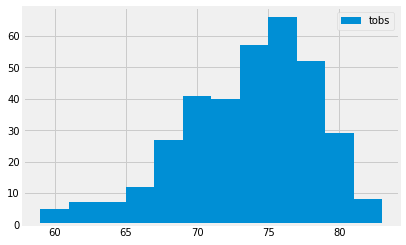

In [312]:
# extract only date from timestamp 
date_twelve = twelve_months_ago.date()
date_twelve

max_station_12 = session.query(Measurement.date,Measurement.station,Measurement.tobs).\
        filter(Measurement.station == 'USC00519281').\
        filter(Measurement.date > date_twelve).all()
#max_station_12

#plotting the results as a histogram

#extract tempature data 
hist_data = pd.DataFrame(max_station_12)

#plot that data
x = hist_data['tobs']
n_bins = 12


fig1, ax1 = plt.subplots()

ax1.hist(x, bins=n_bins)
ax1.legend()
plt.show()


![precipitation](Images/station-histogram.png)

### Temperature Analysis (Optional)

In [134]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [25]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [26]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [27]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [28]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [29]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [30]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [313]:
# Plot the daily normals as an area plot with `stacked=False`


# Testing querys for climate app

In [335]:
results = session.query(Measurement.date,Measurement.prcp).all()

weather_data = []
for weather in results:
    weather_dict = {}    
    weather_dict[weather.date] = weather.prcp
    weather_data.append(weather_dict)

weather_data

[{'2010-01-01': 0.08},
 {'2010-01-02': 0.0},
 {'2010-01-03': 0.0},
 {'2010-01-04': 0.0},
 {'2010-01-06': None},
 {'2010-01-07': 0.06},
 {'2010-01-08': 0.0},
 {'2010-01-09': 0.0},
 {'2010-01-10': 0.0},
 {'2010-01-11': 0.01},
 {'2010-01-12': 0.0},
 {'2010-01-14': 0.0},
 {'2010-01-15': 0.0},
 {'2010-01-16': 0.0},
 {'2010-01-17': 0.0},
 {'2010-01-18': 0.0},
 {'2010-01-19': 0.0},
 {'2010-01-20': 0.0},
 {'2010-01-21': 0.0},
 {'2010-01-22': 0.0},
 {'2010-01-23': 0.0},
 {'2010-01-24': 0.01},
 {'2010-01-25': 0.0},
 {'2010-01-26': 0.04},
 {'2010-01-27': 0.12},
 {'2010-01-28': 0.0},
 {'2010-01-30': None},
 {'2010-01-31': 0.03},
 {'2010-02-01': 0.01},
 {'2010-02-03': None},
 {'2010-02-04': 0.01},
 {'2010-02-05': 0.0},
 {'2010-02-06': 0.0},
 {'2010-02-07': 0.0},
 {'2010-02-08': 0.0},
 {'2010-02-09': 0.0},
 {'2010-02-11': 0.0},
 {'2010-02-12': 0.02},
 {'2010-02-13': 0.01},
 {'2010-02-14': 0.0},
 {'2010-02-15': 0.0},
 {'2010-02-16': 0.0},
 {'2010-02-17': 0.0},
 {'2010-02-19': None},
 {'2010-02-20': 0

('2010-01-01', 0.08)
('2010-01-02', 0.0)
('2010-01-03', 0.0)
('2010-01-04', 0.0)
('2010-01-06', None)
('2010-01-07', 0.06)
('2010-01-08', 0.0)
('2010-01-09', 0.0)
('2010-01-10', 0.0)
('2010-01-11', 0.01)
('2010-01-12', 0.0)
('2010-01-14', 0.0)
('2010-01-15', 0.0)
('2010-01-16', 0.0)
('2010-01-17', 0.0)
('2010-01-18', 0.0)
('2010-01-19', 0.0)
('2010-01-20', 0.0)
('2010-01-21', 0.0)
('2010-01-22', 0.0)
('2010-01-23', 0.0)
('2010-01-24', 0.01)
('2010-01-25', 0.0)
('2010-01-26', 0.04)
('2010-01-27', 0.12)
('2010-01-28', 0.0)
('2010-01-30', None)
('2010-01-31', 0.03)
('2010-02-01', 0.01)
('2010-02-03', None)
('2010-02-04', 0.01)
('2010-02-05', 0.0)
('2010-02-06', 0.0)
('2010-02-07', 0.0)
('2010-02-08', 0.0)
('2010-02-09', 0.0)
('2010-02-11', 0.0)
('2010-02-12', 0.02)
('2010-02-13', 0.01)
('2010-02-14', 0.0)
('2010-02-15', 0.0)
('2010-02-16', 0.0)
('2010-02-17', 0.0)
('2010-02-19', None)
('2010-02-20', 0.03)
('2010-02-21', 0.0)
('2010-02-22', 0.0)
('2010-02-23', 0.0)
('2010-02-24', 0.0)
('20

('2016-04-24', 0.05)
('2016-04-25', 0.0)
('2016-04-26', 0.0)
('2016-04-27', 0.0)
('2016-04-28', 0.0)
('2016-04-29', 0.0)
('2016-04-30', 0.0)
('2016-05-01', 0.0)
('2016-05-02', 0.0)
('2016-05-03', 0.01)
('2016-05-04', 0.0)
('2016-05-05', 0.13)
('2016-05-06', 0.0)
('2016-05-07', 0.03)
('2016-05-08', 0.0)
('2016-05-09', 0.0)
('2016-05-10', 0.0)
('2016-05-11', 0.0)
('2016-05-12', 0.0)
('2016-05-13', 0.0)
('2016-05-14', 0.0)
('2016-05-15', 0.02)
('2016-05-16', 0.0)
('2016-05-17', 0.0)
('2016-05-18', 0.0)
('2016-05-19', 0.0)
('2016-05-20', 0.01)
('2016-05-21', 0.03)
('2016-05-22', 0.0)
('2016-05-23', 0.0)
('2016-05-24', 0.0)
('2016-05-25', 0.0)
('2016-05-26', 0.06)
('2016-05-27', 0.0)
('2016-05-28', 0.1)
('2016-05-29', 0.54)
('2016-05-30', 0.16)
('2016-05-31', 0.05)
('2016-06-01', 0.06)
('2016-06-02', 0.0)
('2016-06-03', 0.0)
('2016-06-04', 0.0)
('2016-06-05', 0.0)
('2016-06-06', 0.0)
('2016-06-07', 0.01)
('2016-06-08', 0.0)
('2016-06-09', 0.01)
('2016-06-10', 0.05)
('2016-06-11', 0.0)
('201

('2014-03-24', 0.0)
('2014-03-25', 0.02)
('2014-03-26', 0.45)
('2014-03-27', 0.4)
('2014-03-28', 1.7)
('2014-03-29', 1.6)
('2014-03-30', 0.93)
('2014-03-31', 0.03)
('2014-04-01', 0.03)
('2014-04-02', 0.2)
('2014-04-03', 0.05)
('2014-04-04', 0.01)
('2014-04-05', 0.03)
('2014-04-06', 0.1)
('2014-04-07', 0.23)
('2014-04-08', 0.02)
('2014-04-09', 0.0)
('2014-04-10', 0.0)
('2014-04-11', 0.01)
('2014-04-12', 0.39)
('2014-04-13', 0.01)
('2014-04-14', 0.01)
('2014-04-15', 0.01)
('2014-04-16', 0.06)
('2014-04-18', 0.05)
('2014-04-19', 0.14)
('2014-04-20', 0.03)
('2014-04-21', 0.09)
('2014-04-22', 0.12)
('2014-04-23', 0.0)
('2014-04-24', 0.0)
('2014-04-25', 0.26)
('2014-04-26', 0.02)
('2014-04-27', 0.2)
('2014-04-28', 0.32)
('2014-04-29', 0.0)
('2014-05-01', 0.02)
('2014-05-02', 0.57)
('2014-05-03', 0.3)
('2014-05-04', 0.01)
('2014-05-05', 0.02)
('2014-05-06', 0.19)
('2014-05-07', 0.0)
('2014-05-08', 0.02)
('2014-05-09', 0.13)
('2014-05-10', 0.09)
('2014-05-11', 0.17)
('2014-05-12', 0.48)
('2014

('2012-12-03', None)
('2012-12-04', 0.0)
('2012-12-05', 0.08)
('2012-12-06', 0.0)
('2012-12-07', 0.0)
('2012-12-10', None)
('2012-12-11', 0.0)
('2012-12-12', 0.03)
('2012-12-13', 0.25)
('2012-12-14', 0.22)
('2012-12-17', None)
('2012-12-18', 0.22)
('2012-12-19', 0.29)
('2012-12-21', None)
('2012-12-22', 0.0)
('2012-12-24', None)
('2012-12-26', None)
('2012-12-28', None)
('2012-12-31', None)
('2013-01-02', None)
('2013-01-03', 0.28)
('2013-01-04', 0.07)
('2013-01-05', 0.2)
('2013-01-07', None)
('2013-01-08', 0.02)
('2013-01-09', 0.44)
('2013-01-10', 0.09)
('2013-01-11', 0.0)
('2013-01-14', None)
('2013-01-15', 0.77)
('2013-01-16', 0.0)
('2013-01-17', 0.02)
('2013-01-18', 0.0)
('2013-01-19', 0.03)
('2013-01-21', None)
('2013-01-22', 0.0)
('2013-01-23', 0.0)
('2013-01-24', 0.45)
('2013-01-25', 0.09)
('2013-01-26', 0.0)
('2013-01-28', None)
('2013-01-29', 0.68)
('2013-01-30', 0.02)
('2013-01-31', 0.01)
('2013-02-01', 0.0)
('2013-02-03', None)
('2013-02-04', 0.0)
('2013-02-05', 0.06)
('2013

('2013-08-07', None)
('2013-08-08', 0.0)
('2013-08-09', 0.0)
('2013-08-12', None)
('2013-08-13', 0.0)
('2013-08-14', 0.04)
('2013-08-15', 0.0)
('2013-08-19', None)
('2013-08-20', None)
('2013-08-21', None)
('2013-08-22', None)
('2013-08-26', None)
('2013-08-27', 0.0)
('2013-08-28', 0.0)
('2013-08-29', 0.05)
('2013-09-03', None)
('2013-09-04', 0.0)
('2013-09-05', 0.0)
('2013-09-06', 0.0)
('2013-09-09', None)
('2013-09-10', 0.0)
('2013-09-11', 0.0)
('2013-09-12', 0.0)
('2013-09-13', 0.3)
('2013-09-16', None)
('2013-09-17', None)
('2013-09-18', None)
('2013-09-19', None)
('2013-09-20', 0.0)
('2013-09-26', 0.2)
('2013-09-27', 0.03)
('2013-09-30', None)
('2013-10-01', None)
('2013-10-02', None)
('2013-10-03', 0.0)
('2013-10-04', None)
('2013-10-07', None)
('2013-10-08', 0.0)
('2013-10-11', 0.0)
('2013-10-14', None)
('2013-10-15', None)
('2013-10-16', 0.05)
('2013-10-17', 0.0)
('2013-10-18', 0.0)
('2013-10-22', 0.0)
('2013-10-23', 0.0)
('2013-10-24', 0.0)
('2013-10-25', None)
('2013-10-28', 

('2011-12-30', 0.0)
('2011-12-31', 0.0)
('2012-01-01', 0.0)
('2012-01-02', 0.0)
('2012-01-03', 0.0)
('2012-01-04', 0.0)
('2012-01-05', 0.0)
('2012-01-06', 0.0)
('2012-01-07', 0.0)
('2012-01-08', 0.0)
('2012-01-09', 0.08)
('2012-01-10', 0.0)
('2012-01-11', 0.0)
('2012-01-12', 0.0)
('2012-01-13', 0.0)
('2012-01-14', 0.0)
('2012-01-15', 0.0)
('2012-01-16', 0.0)
('2012-01-17', 0.13)
('2012-01-18', 0.07)
('2012-01-19', 0.0)
('2012-01-20', 0.0)
('2012-01-21', 0.0)
('2012-01-22', 0.0)
('2012-01-23', 0.0)
('2012-01-24', 0.0)
('2012-01-25', 0.0)
('2012-01-26', 0.0)
('2012-01-27', 0.08)
('2012-01-28', 0.0)
('2012-01-29', 0.09)
('2012-01-30', 0.01)
('2012-01-31', 0.1)
('2012-02-01', 0.0)
('2012-02-02', 0.0)
('2012-02-03', 0.0)
('2012-02-04', 0.0)
('2012-02-05', 0.0)
('2012-02-06', 0.29)
('2012-02-07', 0.49)
('2012-02-08', 0.41)
('2012-02-09', 0.03)
('2012-02-10', 0.0)
('2012-02-11', 0.0)
('2012-02-12', 0.0)
('2012-02-13', 0.09)
('2012-02-14', 0.0)
('2012-02-15', 0.04)
('2012-02-16', 0.0)
('2012-0

('2010-02-23', 0.0)
('2010-02-24', 0.0)
('2010-02-25', 0.0)
('2010-02-26', 0.01)
('2010-02-27', 0.0)
('2010-02-28', 0.12)
('2010-03-01', 0.01)
('2010-03-02', 0.0)
('2010-03-03', 0.0)
('2010-03-04', 0.4)
('2010-03-05', 0.33)
('2010-03-06', 0.51)
('2010-03-07', 0.08)
('2010-03-08', 0.53)
('2010-03-09', 0.04)
('2010-03-10', 0.45)
('2010-03-11', 0.01)
('2010-03-12', 0.12)
('2010-03-13', 0.0)
('2010-03-14', 0.0)
('2010-03-15', 0.23)
('2010-03-16', 0.5)
('2010-03-17', 0.19)
('2010-03-18', 0.69)
('2010-03-19', 0.19)
('2010-03-20', 0.0)
('2010-03-21', 0.05)
('2010-03-22', 0.0)
('2010-03-23', 0.0)
('2010-03-24', 0.02)
('2010-03-25', 0.06)
('2010-03-26', 0.12)
('2010-03-27', 0.0)
('2010-03-28', 0.0)
('2010-03-29', 0.01)
('2010-03-30', 0.03)
('2010-03-31', 0.0)
('2010-04-01', 0.03)
('2010-04-02', 0.11)
('2010-04-03', 0.18)
('2010-04-04', 0.11)
('2010-04-05', 0.57)
('2010-04-06', 0.16)
('2010-04-07', 3.99)
('2010-04-08', 0.1)
('2010-04-09', 0.01)
('2010-04-10', 0.14)
('2010-04-11', 0.02)
('2010-04

('2015-08-20', 0.0)
('2015-08-21', 1.62)
('2015-08-22', 0.03)
('2015-08-23', 2.86)
('2015-08-24', 3.62)
('2015-08-25', 0.31)
('2015-08-26', 0.6)
('2015-08-27', 2.96)
('2015-08-28', 0.05)
('2015-08-29', 0.01)
('2015-08-30', 0.05)
('2015-08-31', 0.02)
('2015-09-01', 0.3)
('2015-09-02', 0.01)
('2015-09-03', 0.0)
('2015-09-04', 1.35)
('2015-09-05', 0.0)
('2015-09-06', 0.0)
('2015-09-07', 0.97)
('2015-09-08', 0.74)
('2015-09-09', 0.0)
('2015-09-10', 0.09)
('2015-09-11', 0.69)
('2015-09-12', 3.1)
('2015-09-13', 0.26)
('2015-09-14', 0.52)
('2015-09-15', 1.61)
('2015-09-16', 0.41)
('2015-09-17', 0.07)
('2015-09-18', 0.42)
('2015-09-19', 0.07)
('2015-09-20', 0.25)
('2015-09-21', 0.63)
('2015-09-22', 0.37)
('2015-09-23', 0.48)
('2015-09-24', 0.11)
('2015-09-25', 0.2)
('2015-09-26', 0.49)
('2015-09-27', 0.45)
('2015-09-28', 0.77)
('2015-09-29', 0.8)
('2015-09-30', 0.14)
('2015-10-01', 0.0)
('2015-10-02', 0.06)
('2015-10-03', 0.0)
('2015-10-04', 0.09)
('2015-10-05', 1.46)
('2015-10-06', 0.19)
('20

('2013-07-29', 0.02)
('2013-07-30', 0.5)
('2013-07-31', 0.01)
('2013-08-01', 0.0)
('2013-08-02', 0.0)
('2013-08-03', 0.0)
('2013-08-04', 0.0)
('2013-08-05', 0.0)
('2013-08-06', 0.0)
('2013-08-07', 0.0)
('2013-08-08', 0.0)
('2013-08-09', 0.0)
('2013-08-10', 0.07)
('2013-08-11', 0.0)
('2013-08-12', 0.0)
('2013-08-13', 0.0)
('2013-08-14', 0.0)
('2013-08-15', 0.0)
('2013-08-16', 0.01)
('2013-08-17', 0.0)
('2013-08-18', 0.0)
('2013-08-19', 0.0)
('2013-08-20', 0.0)
('2013-08-21', 0.0)
('2013-08-22', 0.0)
('2013-08-23', 0.0)
('2013-08-24', 0.0)
('2013-08-25', 0.0)
('2013-08-26', 0.0)
('2013-08-27', 0.0)
('2013-08-28', 0.0)
('2013-08-29', 0.06)
('2013-08-30', 0.0)
('2013-08-31', 0.0)
('2013-09-01', 0.35)
('2013-09-02', 0.0)
('2013-09-03', 0.0)
('2013-09-04', 0.0)
('2013-09-05', 0.0)
('2013-09-06', 0.0)
('2013-09-07', 0.05)
('2013-09-08', 0.01)
('2013-09-09', 0.0)
('2013-09-10', 0.0)
('2013-09-11', 0.0)
('2013-09-12', 0.0)
('2013-09-13', 0.22)
('2013-09-14', 0.14)
('2013-09-15', 0.16)
('2013-09

('2015-03-30', 0.72)
('2015-03-31', 1.5)
('2015-04-01', 0.48)
('2015-04-02', 0.47)
('2015-04-04', None)
('2015-04-05', 0.32)
('2015-04-07', None)
('2015-04-08', 0.23)
('2015-04-09', 0.08)
('2015-04-10', 0.0)
('2015-04-11', 0.09)
('2015-04-12', 0.73)
('2015-04-13', 0.28)
('2015-04-14', 0.74)
('2015-04-15', 0.62)
('2015-04-16', 0.17)
('2015-04-17', 1.2)
('2015-04-18', 0.05)
('2015-04-19', 0.09)
('2015-04-21', None)
('2015-04-22', 1.68)
('2015-04-23', 0.06)
('2015-04-24', 0.37)
('2015-04-25', 0.04)
('2015-04-26', 0.05)
('2015-04-27', 0.63)
('2015-04-28', 3.26)
('2015-04-29', 0.45)
('2015-04-30', 0.14)
('2015-05-01', 1.79)
('2015-05-02', 0.0)
('2015-05-03', 0.0)
('2015-05-04', 0.21)
('2015-05-05', 1.27)
('2015-05-06', 0.02)
('2015-05-07', 0.04)
('2015-05-08', 1.88)
('2015-05-09', 0.67)
('2015-05-10', 0.92)
('2015-05-11', 0.27)
('2015-05-12', 0.08)
('2015-05-13', 0.02)
('2015-05-14', 0.84)
('2015-05-15', 0.58)
('2015-05-16', 0.12)
('2015-05-17', 0.0)
('2015-05-18', 0.22)
('2015-05-19', 0.0)